In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

# basic read and show image function in open cv
image = cv2.imread('test_image.jpg')

# convert color image to gray, and smooth
copied_image = np.copy(image) # process with the copied image to avoid interference of the oringinal image
gray_image = cv2.cvtColor(copied_image, cv2.COLOR_RGB2GRAY) # convert image to gray scale
# use Gaussian Blur to reduce noise and smooth image, commanly used kernel size (5*5)
blur_image = cv2.GaussianBlur(gray_image, (5,5), 0) 
plt.imshow(image)
plt.show()

# detect edges using optimal detector: canny
# beyond maxValue: sure-edge, below minValue: sure-not-edge
edge_image = cv2.Canny(blur_image, 50, 150)
plt.imshow(edge_image)
plt.show()

<Figure size 640x480 with 1 Axes>

<Figure size 640x480 with 1 Axes>

In [2]:
# find region of interest, according to the given image 
# use a triagnle to intersect with the edge image to find middle lane and right lane

def region_of_interest(image):
    height, width = image.shape
    polygons = np.array([[(200,height),(1100,height),(550,250)]])
    mask = np.zeros_like(image)
    cv2.fillPoly(mask, polygons,255)
    masked_image = cv2.bitwise_and(mask,image)
    return masked_image
    

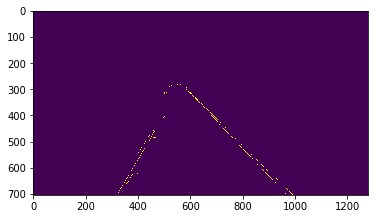

In [3]:
masked_image = region_of_interest(edge_image)
plt.imshow(masked_image)
plt.show()

In [4]:
# get edges of the given image
def get_edge_image(image):
    copied_image = np.copy(image)
    gray_image = cv2.cvtColor(copied_image, cv2.COLOR_RGB2GRAY)
    blur_image = cv2.GaussianBlur(gray_image,(5,5),0)
    edge_image = cv2.Canny(blur_image, 50,150)
    return edge_image

In [5]:
found_lines = cv2.HoughLinesP(masked_image, 2, np.pi/180, 100, np.array([]),minLineLength = 40, maxLineGap = 5)
print('parameters of found lines',found_lines.reshape(-1,4))


parameters of found lines [[704 418 927 641]
 [704 426 791 516]
 [320 703 445 494]
 [585 301 663 381]
 [630 341 670 383]
 [794 520 861 591]
 [659 371 704 416]
 [870 599 939 672]
 [767 493 807 534]
 [423 509 454 461]
 [940 653 991 702]
 [824 551 879 609]
 [676 389 754 467]]


In [6]:
def find_lines(image):
    found_lines = cv2.HoughLinesP(image, 2, np.pi/180, 100, np.array([]),minLineLength = 40, maxLineGap = 5)
    return found_lines.reshape(-1,4)

In [7]:
found_lines = find_lines(masked_image)

In [8]:
# draw the detected lines on a empty image
def draw_lines(image, lines):
    line_image = np.zeros_like(image)
    if lines is not None:
        for line in lines:
            x1,y1,x2,y2 = line.reshape(4)
            cv2.line(line_image, (x1,y1),(x2,y2),(255,0,0), 10)
    return line_image

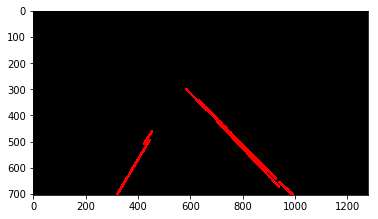

In [9]:
# check draw_lines function
line_image = draw_lines(image, found_lines)
plt.imshow(line_image)
plt.show()

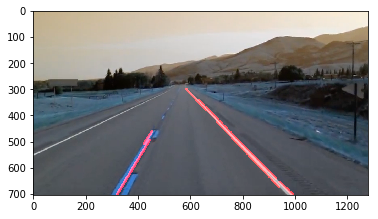

In [10]:
# combine the image with only line and the original image 
combine_line_lane_image = cv2.addWeighted(line_image,0.8, image, 1,1)
plt.imshow(combine_line_lane_image)
plt.show()

In [11]:
# determine the line with average slope and intercept of all found lines
def find_average_lines(image, lines):
    left_fit = []
    right_fit = []
    for line in lines:
        x1,y1,x2,y2 = line.reshape(4)
        parameters = np.polyfit((x1,x2),(y1,y2),1)
        slope = parameters[0]
        intercept = parameters[1]
        if slope < 0:
            left_fit.append((slope,intercept))
        else :
            right_fit.append((slope, intercept))
    left_average = np.average(left_fit,axis = 0)
    right_average = np.average(right_fit,axis = 0)
    left_line = make_coordinates(image, left_average)
    right_line = make_coordinates(image, right_average)
    return np.array([left_line, right_line])

In [12]:
# design the coordinates on which the averaged line to be drawn
def make_coordinates(image, line_parameters):
    slope, intercept = line_parameters
    y1 = image.shape[0]
    y2 = int(y1*3/5)
    x1 = int((y1-intercept)/slope)
    x2 = int((y2-intercept)/slope)
    return np.array([x1,y1,x2,y2])

In [13]:
averaged_lines = find_average_lines(image, found_lines)
print(averaged_lines)

[  -1.61019355 1201.00387097]
[[308 704 483 422]
 [978 704 703 422]]


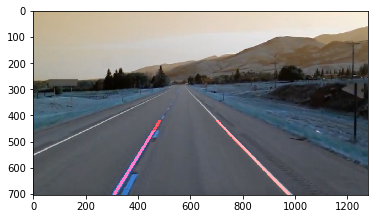

In [14]:
averaged_line_image = draw_lines(image, averaged_lines)
combine_ave_line_lane = cv2.addWeighted(averaged_line_image,0.8, image,1,1)
plt.imshow(combine_ave_line_lane)
plt.show()

In [16]:
# capture a video
cap = cv2.VideoCapture('test2.mp4')
while(cap.isOpened()):
    _,frame = cap.read()
    copied_image = np.copy(frame)
    edge_image = get_edge_image(copied_image)
    masked_image = region_of_interest(edge_image)
    found_lines = find_lines(masked_image)
    found_lines = find_average_lines(frame, found_lines)
    print(found_lines)
    line_image = draw_lines(copied_image,found_lines)
    combine_line_lane = cv2.addWeighted(line_image, 0.8, copied_image,1,1)
    cv2.imshow('result',combine_line_lane)
    if cv2.waitKey(25) & 0xFF == ord('a'):
        break
cap.release()
cv2.destroyAllWindows()

[  -1.87340799 1356.76218709]
[[ 339  720  493  432]
 [1020  720  723  432]]
[  -1.88435374 1359.94557823]
[[ 339  720  492  432]
 [1021  720  725  432]]
[  -1.78200297 1302.18676705]
[[ 326  720  488  432]
 [1020  720  722  432]]
[  -1.78200297 1302.18676705]
[[ 326  720  488  432]
 [1020  720  722  432]]
[  -1.88206973 1356.38840181]
[[ 338  720  491  432]
 [1020  720  725  432]]
[  -1.77854887 1294.98519468]
[[ 323  720  485  432]
 [1021  720  725  432]]
[  -1.77854887 1294.98519468]
[[ 323  720  485  432]
 [1021  720  725  432]]
[  -1.76630363 1292.859795  ]
[[ 324  720  487  432]
 [1020  720  723  432]]
[  -1.76630363 1292.859795  ]
[[ 324  720  487  432]
 [1020  720  723  432]]
[  -1.87712447 1351.57067535]
[[ 336  720  489  432]
 [1013  720  719  432]]
[  -1.87712447 1351.57067535]
[[ 336  720  489  432]
 [1013  720  719  432]]
[  -1.87413206 1349.75890004]
[[ 336  720  489  432]
 [1017  720  720  432]]
[  -1.88740322 1355.0395802 ]
[[ 336  720  489  432]
 [1013  720  719  432]]

[  -1.7095478  1249.90787819]
[[309 720 478 432]
 [993 720 704 432]]
[  -1.78921719 1286.62287281]
[[316 720 477 432]
 [991 720 703 432]]
[  -1.78921719 1286.62287281]
[[316 720 477 432]
 [991 720 703 432]]
[  -1.74796634 1266.14628331]
[[312 720 477 432]
 [997 720 704 432]]
[  -1.72417582 1256.98901099]
[[311 720 478 432]
 [992 720 704 432]]
[  -1.6996337  1246.91819292]
[[310 720 479 432]
 [993 720 704 432]]
[  -1.6996337  1246.91819292]
[[310 720 479 432]
 [993 720 704 432]]
[  -1.72334402 1255.74353632]
[[ 310  720  477  432]
 [1000  720  705  432]]
[  -1.68810734 1242.32640487]
[[ 309  720  480  432]
 [1000  720  706  432]]
[  -1.75581395 1269.11627907]
[[312 720 476 432]
 [999 720 706 432]]
[  -1.70005981 1244.68450957]
[[308 720 478 432]
 [998 720 708 432]]
[  -1.70005981 1244.68450957]
[[308 720 478 432]
 [998 720 708 432]]
[  -1.67890512 1235.60729817]
[[ 307  720  478  432]
 [1002  720  708  432]]
[  -1.70167795 1244.69227069]
[[308 720 477 432]
 [996 720 707 432]]
[  -1.6723

D:\ProgramData\Anaconda3\lib\site-packages\numpy\lib\function_base.py:1128: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis)
D:\ProgramData\Anaconda3\lib\site-packages\numpy\core\_methods.py:80: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


TypeError: 'numpy.float64' object is not iterable